# KNN


- **This model has another data imputation, different from the EDA**

- Load libaries and data.

In [17]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Data
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

### **MODELING**

- Split the data (train test split)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

#### **DATA IMPUTATION**

- Separate numerical columns from categorical ones.

In [19]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

- Pipeline to imput the data (using KNNImputer and a StandardScaler to normalise the data).

In [20]:
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),  # Imputación KNN
    ('scaler', StandardScaler())  # Escalado estándar
])

In [21]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificación One-Hot
])

- Transformer to preprocess the imputation of data.

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

**Model with pipeline (using the preprocesser for imputation and the classifier (KNN))**

In [23]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])


- Establish param grid and make the Grid Search for Cross Validation. Then, fit the best estimators.

In [24]:
param_grid = {'classifier__n_neighbors': np.arange(1, 21)}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_o...
       'census_msa_Non-MSA', 'hhs_geo_region', 'employment_industry',
       'employment_occupation'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

- Prediction with the best estimator.

In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test)

- Obtain the best k value for kNN

In [26]:
print(f"Mejor valor de k: {grid_search.best_params_['classifier__n_neighbors']}")
# print(f"Precisión del modelo optimizado: {accuracy_score(y_test, y_pred):.2f}")
# print("\nReporte de Clasificación:")
# print(classification_report(y_test, y_pred))

Mejor valor de k: 19


- Save the prediction in a dataframe (one column for each prediction of label).

In [27]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': y_pred[0][:,1],
        'seasonal_vaccine':y_pred[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.052632,0.263158
1215,0.526316,0.789474
10540,0.105263,0.210526
7407,0.052632,0.421053
14697,0.105263,0.157895


### **RESULTS: ROC CURVE**

- Method to plot ROC Curve.

In [28]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

- Plot the roc curves of each prediction.

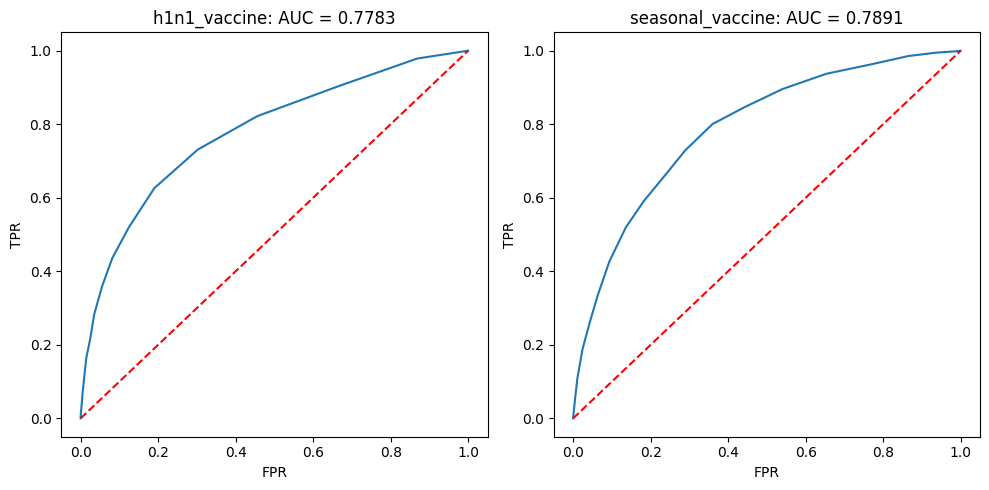

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

### **MAKE AND SAVE THE PREDICTIONS FOR THE COMPETITION**

In [30]:
grid_search.fit(X_train_df, training_set_labels_df)
preds = grid_search.predict_proba(X_test_df)
preds

[array([[0.94736842, 0.05263158],
        [1.        , 0.        ],
        [0.47368421, 0.52631579],
        ...,
        [0.89473684, 0.10526316],
        [0.89473684, 0.10526316],
        [0.73684211, 0.26315789]]),
 array([[0.78947368, 0.21052632],
        [0.94736842, 0.05263158],
        [0.21052632, 0.78947368],
        ...,
        [0.78947368, 0.21052632],
        [0.52631579, 0.47368421],
        [0.36842105, 0.63157895]])]

In [31]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.052632,0.210526
26708,0.000000,0.052632
26709,0.526316,0.789474
26710,0.368421,0.894737
26711,0.263158,0.473684


In [32]:
y_preds.to_csv('../results/pred_KNN_output.csv', index = True)